---

# **Final Project**

- Data Analyst: Rangga Irwanto Putra Kiat
- Data Scientist: Achmad Ghulam Habib Al-widani
- Data Scientist: Muhammad Afza Nur Hakim
- Data Engineer: Muhammad Aldzahabi Mawarid
- Batch             : HCK-034
- Group             : 01
---

### Problem Statement

Meningkatnya penggunaan teknologi AI generatif dalam pembuatan karya visual menimbulkan tantangan serius dalam proses identifikasi keaslian karya, terutama pada skala besar seperti lomba atau seleksi terbuka. Karya non-AI memiliki keragaman visual yang sangat tinggi, mencakup berbagai gaya seni, medium, dan teknik, sehingga membentuk kelas yang tidak homogen dan sulit didefinisikan secara konsisten. Kondisi ini semakin diperumit oleh munculnya karya digital modern yang secara visual semakin menyerupai hasil AI-generated, menyebabkan tumpang tindih karakteristik visual antara karya AI dan non-AI. 

Proses identifikasi manual maupun otomatis berisiko mengalami kesalahan, khususnya dalam bentuk lolosnya karya AI sebagai karya non-AI (false negative), yang dapat mengancam integritas seleksi. Di sisi lain, keterbatasan waktu dan sumber daya membuat proses pemeriksaan mendalam terhadap seluruh karya menjadi tidak efisien. Oleh karena itu, dibutuhkan sebuah mekanisme penyaringan awal yang mampu memprioritaskan deteksi karya berpotensi AI-generated secara waspada, sehingga proses verifikasi lanjutan dapat difokuskan secara lebih efektif tanpa mengorbankan keadilan dan akurasi keputusan akhir.

### Objective

Berdasarkan permasalahan identifikasi keaslian karya visual dalam konteks penggunaan AI generatif, tujuan yang ingin dicapai dalam project ini antara lain:

* **Penyaringan Awal Karya Visual:** Menyediakan mekanisme penyaringan awal untuk mengidentifikasi karya visual yang berpotensi AI-generated dalam jumlah besar secara cepat dan efisien.
* **Minimisasi Risiko False Negative:** Mengutamakan pendeteksian karya AI-generated guna meminimalkan risiko lolosnya karya AI yang diklasifikasikan sebagai non-AI, terutama dalam konteks seleksi atau lomba seni.
* **Dukungan Proses Verifikasi Bertahap:** Membantu proses seleksi dengan mengarahkan karya yang terindikasi AI-generated ke tahap pemeriksaan lanjutan, sehingga verifikasi mendalam dapat dilakukan secara lebih terfokus dan efisien.
* **Efisiensi Waktu dan Sumber Daya:** Mengurangi beban kerja manual reviewer dengan menyediakan alat bantu awal yang mampu menangani volume data besar tanpa mengorbankan integritas dan keadilan proses seleksi.


#### Sumber Dataset

- URL Dataset Kaggle (https://www.kaggle.com/datasets/kausthubkannan/ai-and-human-art-classification/discussion/479343)

# **A. Import Libraries**

In [ ]:
# Core & Utilities
import os
import random
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D, MaxPooling2D,
    Dense, Dropout,
    GlobalAveragePooling2D,
    BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Image Processing
from tensorflow.keras.preprocessing import image
from PIL import Image


# Evaluation (Sklearn)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# **B. Data Loading**

In [ ]:
# menentukan resolusi gambar dan path directory
IMG_SIZE = 224

# Path train
train_path = "train"

# Path test 
val_path = "val"

# Path val
test_path = "test"

# Generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load Main Dataset ()
train_data = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    seed=2
)

# Load Test Dataset (Test)
val_data = datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 10880 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Pada tahap data loading ini, data gambar hanya diambil dan disiapkan untuk keperluan eksplorasi data (EDA), bukan untuk langsung melatih model. Proses yang dilakukan sebatas memuat gambar dari folder train, validation, dan test, menyamakan ukuran gambar menjadi 224×224 (standar awal yang biasa digunakan untuk project computer vision yang memiliki balance yang baik antara pemrosesan gambar dan computational cost), serta menyesuaikan nilai piksel agar lebih mudah dianalisis dan ditampilkan. Tahap ini digunakan untuk melihat jumlah data, memastikan pembagian kelas sudah benar, dan memahami kondisi dataset secara umum. Belum ada proses preprocessing atau augmentasi yang ditujukan untuk meningkatkan performa model, karena langkah-langkah tersebut akan dilakukan secara terpisah pada tahap pelatihan. Dengan kata lain, data loading di sini bertujuan agar peneliti memahami data terlebih dahulu sebelum masuk ke proses training model yang sebenarnya.

# **C. Feature Engineering (Base Model CNN)**

#### Augmentation (Base Model CNN)

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 2

# Path
train_path = "train"
val_path   = "val"
test_path  = "test"

# TRAIN (Augmentation)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

# VAL
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary",
    shuffle=False
)

# TEST 
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_set.class_indices)

Found 10880 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Class indices: {'AI_GENERATED': 0, 'NON_AI_GENERATED': 1}


Dilakukan data augmentation dan persiapan data untuk meningkatkan performa model dengan penjelasan sebagai berikut:

- Menggunakan ImageDataGenerator dengan parameter rotation_range=10 (sedikit diputar), width_shift_range=0.05 (digeser secara horizontal), height_shift_range=0.05 (digeser secara vertikal), zoom_range=0.1 (diperbesar), dan horizontal_flip=True (dibalik) pada Train Dataset saja. Proses ini bertujuan agar model dilatih pada berbagai variasi kondisi gambar, sehingga model lebih robust dan mampu mempelajari pola yang lebih umum tanpa menghafal posisi atau bentuk gambar tertentu.

- Pemisahan data Training, Validation, dan Test dilakukan berdasarkan variabel jalur folder (train_path, val_path, test_path). Data Training digunakan untuk melatih model, data Validation digunakan untuk memantau performa model selama pelatihan (mencegah overfitting), dan data Test digunakan untuk pengujian akhir pada data yang benar-benar baru. Data validation dan test tidak diberi augmentasi tambahan agar evaluasi tetap objektif terhadap data asli.

- Normalisasi (rescaling) data dilakukan dengan rescale=1./255 pada ketiga dataset. Proses ini sangat penting untuk mengubah rentang nilai pixel dari 0–255 menjadi 0–1. Hal ini membantu stabilitas perhitungan numerik, mempercepat konvergensi saat proses training, dan memastikan bobot model tidak didominasi oleh nilai input yang terlalu besar.

- Proses resizing gambar diterapkan secara konsisten menggunakan target_size=(224, 224). Karena gambar asli dalam dataset seringkali memiliki dimensi yang berbeda-beda, penyeragaman ukuran menjadi 224x224 piksel diperlukan agar sesuai dengan arsitektur input model CNN yang akan digunakan.

- Pengaturan Shuffle data diterapkan pada data training (shuffle=True) dengan SEED=2 agar urutan gambar diacak setiap epoch, sehingga model tidak mempelajari urutan file. Sebaliknya, pada data validation dan test, shuffle=False digunakan untuk memastikan urutan data tetap konsisten, memudahkan analisis hasil prediksi seperti pada confusion matrix.

- Penentuan Batch Size dan Class Mode dilakukan dengan batch_size=32 untuk mengoptimalkan penggunaan memori GPU/RAM saat proses iterasi. Penggunaan class_mode="binary" menunjukkan bahwa dataset ini ditujukan untuk klasifikasi dua kelas (biner). Nama dan indeks kelas diambil secara otomatis dari struktur sub-folder di dalam direktori dataset melalui fungsi flow_from_directory

# **D. Model Defitinition (Base Model CNN)**

#### Clearing Session

In [ ]:
SEED = 2  

tf.keras.backend.clear_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

Proses clear session digunakan untuk mengosongkan memori dan menghapus sisa konfigurasi model serta cache yang pernah dijalankan sebelumnya. Langkah ini memastikan bahwa setiap proses pelatihan dimulai dalam kondisi bersih, sehingga model membangun pembelajaran sepenuhnya dari awal tanpa dipengaruhi oleh proses training terdahulu

#### Sequential API (Base Mode CNN)

In [ ]:
IMG_SIZE = 224
SEED = 2

he_init = tf.keras.initializers.HeNormal(seed=SEED)

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), padding='same', activation='relu',
           kernel_initializer=he_init, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Dropout(0.15),

    # Block 2
    Conv2D(64, (3,3), padding='same', activation='relu',
           kernel_initializer=he_init),
    MaxPooling2D(2,2),
    Dropout(0.20),

    # Block 3
    Conv2D(128, (3,3), padding='same', activation='relu',
           kernel_initializer=he_init),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Head
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_initializer=he_init),
    Dropout(0.40),

    # Output (binary)
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Berikut penjelasan detail untuk base model:

- Model menggunakan Sequential API, di mana layer disusun secara berurutan mulai dari input layer, hidden layer, hingga output layer. Sequential API dipilih karena arsitektur model bersifat linear dan sederhana, memudahkan aliran data dari ekstraksi fitur menuju klasifikasi

- CNN (Convolutional Neural Network) digunakan karena kemampuannya yang sangat baik dalam melakukan ekstraksi fitur spasial pada gambar. Dengan menggunakan filter, CNN dapat menangkap pola visual seperti tepi, tekstur, hingga bentuk objek yang kompleks.

- Penerapan CNN dilakukan dalam layer bertahap sebagai berikut: pertama covolutional layer (Conv2D) dengan jumlah filter yang meningkat (32, 64, dan 128) serta ukuran kernel (3, 3). Layer ini berfungsi untuk mendeteksi pola, tekstur, dan fitur penting pada gambar dengan cara operasi konvolusi secara bergeser ke samping kemudian ke bawah, penggunaan padding='same' memastikan ukuran output tetap sama dengan input setelah konvolusi, sehingga informasi di pinggir gambar tidak hilang, kedua max pooling layar dengan ukuran (2, 2) digunakan untuk mereduksi dimensi hasil konvolusi, proses ini menyederhanakan representasi data sehingga mempercepat komputasi dan mengurangi resiko overfitting, ketiga dropout layer, diterapkan setelah proses pooling dengan nilai yang meningkat (0.15, 0.20, dan 0.25), ini berfungsi mencegah overfitting dengan mematikan neuron secara acak agar model tidak terlalu bergantung pada pixel tertentu

- HeNormal Initializer (he_init) digunakan untuk menginisialisasi bobot awal jaringan. Teknik ini sangat efektif dipasangkan dengan fungsi aktivasi ReLU karena membantu menjaga varians sinyal agar tidak meledak atau menghilang (vanishing gradient), sehingga proses training menjadi lebih stabil sejak awal.

- GlobalAveragePooling2D untuk layer yang mengambil rata-rata dari setiap feature map. Hal ini mengurangi jumlah parameter model, sehingga mengurangi risiko overfitting dan membuat model lebih ringan

- Fully Connected (Dense) Layer dengan 128 neuron dan fungsi aktivasi ReLU berperan sebagai hidden layer terakhir untuk mengolah fitur yang telah diektraksi. Diterapkan juga Dropout 0.40 yang cukup besar untuk memastikan generalisasi model yang kuat sebelum memasuki tahap klasifikasi

- Output Layer menggunakan Dense layer dengan 1 neuron dan fungsi aktivasi Sigmoid, yang tepat untuk klasifikasi biner (dua kelas). Sigmoid akan menghasilkan output berupa probabilitas antara 0 dan 1, di mana nilai di atas 0.5 biasanya dikategorikan sebagai kelas positif

- Proses kompilasi model dilakukan dengan loss function binary_crossentropy karena target output bersifat biner, optimizer Adam dengan learning rate 3e-4 (0.0003) karena nilai ini merupakan nilai awal yang stabil untuk memastikan model belajar secara bertahap tanpa melewati titik optimal, serta metrik accuracy untuk memantau sejauh mana model berhasil memprediksi label dengan benar 

#### Model Training

In [ ]:
# Early Stopping Callback
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
# Checkpoint
checkpoint = ModelCheckpoint(
    filepath="best_base_cnn.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Training Model
history = model.fit(
    train_set,
    epochs=30,
    validation_data=val_set,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5856 - loss: 0.6899
Epoch 1: val_loss improved from inf to 0.59101, saving model to best_base_cnn.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 420ms/step - accuracy: 0.5857 - loss: 0.6898 - val_accuracy: 0.7050 - val_loss: 0.5910
Epoch 2/30
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6967 - loss: 0.5803
Epoch 2: val_loss improved from 0.59101 to 0.58956, saving model to best_base_cnn.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 151s 443ms/step - accuracy: 0.6967 - loss: 0.5803 - val_accuracy: 0.7045 - val_loss: 0.5896
Epoch 3/30
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7194 - loss: 0.5551
Epoch 3: val_loss improved from 0.58956 to 0.56085, saving model to best_base_cnn.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 161s 472ms/step - accuracy: 0.7194 - loss: 0.5550 - val_accuracy: 0.7255 - val_loss: 0.5609
Epoch 4/30
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.7404 - loss: 0.5264
Epoch 4: val_loss improve

Proses pelatihan model dilakukan menggunakan data training dengan jumlah maksimal 30 epoch. Jumlah epoch ini memberikan ruang yang cukup bagi model untuk mempelajari pola fitur gambar secara mendalam

Mekanisme EarlyStopping diterapkan untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan pada nilai val_loss selama 5 epoch berturut-turut (patience=5). Hal ini sangat penting untuk mencegah overfitting, di mana model mulai menghafal data training tetapi performanya menurun pada data baru. 

Parameter restore_best_weights=True memastikan bahwa setelah berhenti, model yang digunakan adalah model dengan performa terbaik, bukan model di epoch terakhir yang sudah menurun

Penerapan ModelCheckpoint dilakukan untuk menyimpan progress pelatihan secara otomatis ke dalam file best_base_cnn.keras. Dengan parameter save_best_only=True, sistem hanya akan memperbarui file tersebut jika menemukan bobot model yang menghasilkan nilai val_loss terendah dibandingkan epoch sebelumnya. Ini berfungsi sebagai safety net agar hasil terbaik dari proses pelatihan tetap tersimpan meskipun terjadi gangguan teknis

Selama proses training, performa model dievaluasi secara real-time menggunakan val_set melalui parameter validation_data. Hasil evaluasi pada setiap epoch ditampilkan melalui verbose=1, sehingga kita dapat memantau pergerakan nilai loss dan accuracy baik pada data training maupun validation secara transparan

Efisiensi komputasi dijaga dengan menggunakan generator data (train_set dan val_set) yang menyuplai data dalam bentuk batch berukuran 32. Penggunaan batch ini memastikan penggunaan memori (RAM/GPU) tetap stabil dan proses pembaruan bobot melalui optimizer Adam berjalan lebih konsisten di setiap iterasinya



#### Learning Curve (Base Model)

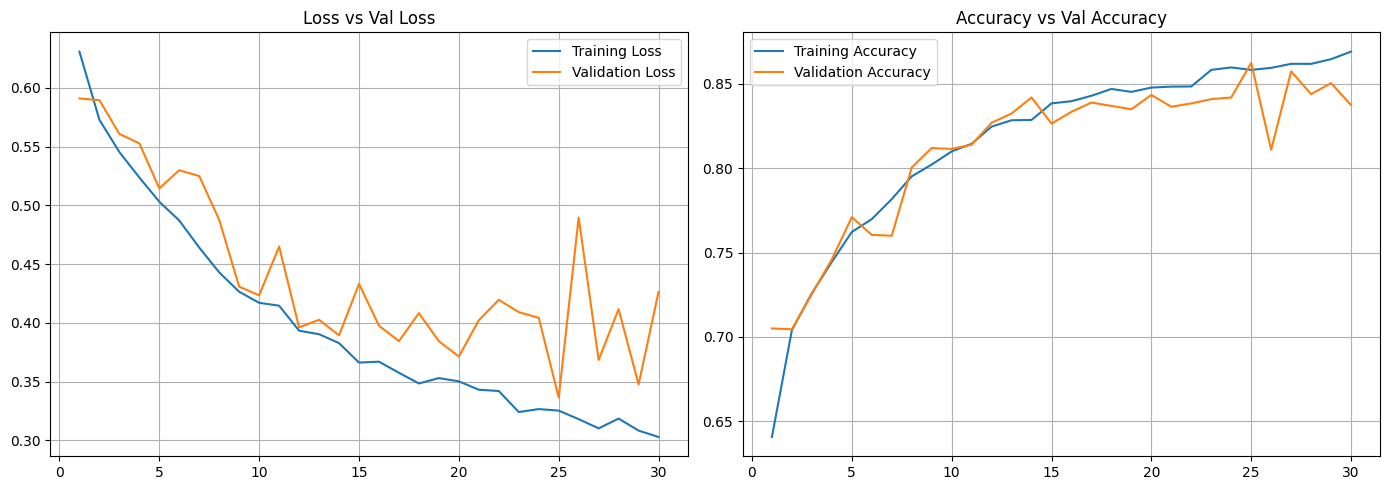

In [15]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs Val Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy vs Val Accuracy')

plt.tight_layout()
plt.show()

Dapat dilakukan evaluasi pada model menggunakan grafik Loss vs Val-Loss serta grafik Accuracy vs Val-Accuracy

**Loss vs Val-Loss Graph**

- Grafik ini menampilkan perbandingan training loss dan validation loss selama 30 epoch
- Training loss (garis biru) mengalami penurunan yang sangat konsisten dan halus, dimulai dari nilai di atas 0.60 hingga mencapai titik terendah sekitar 0.30 pada epoch ke 30. Hal ini menunjukkan proses optimasi bobot pada data train berjalan dengan baik
- Validation loss (garis oranye) menunjukkan tren menurun secara umum, namun terlihat sangat fluktuatif dengan kenaikan dan penurunan tajam terutama setelah epoch ke-10, dengan titik terendah berada di sekitar epoch ke-25 (0.34) sebelum naik kembali
- Meskipun kedua garis menunjukkan tren menurun (konvergen), fluktuasi yang tajam pada validation loss mengindikasikan bahwa model masih mengalami kesulitan dalam menstabilkan prediksi pada data yang belum pernah dilihat sebelumnya

**Accuracy vs Val-Accuracy Graph**

- Grafik ini menunjukkan perkembangan akurasi model selama 30 epoch proses pelatihan
- Training accuracy (garis biru) meningkat secara stabil dari sekitar 64% pada epoch pertama hingga mencapai puncaknya di sekitar 87% pada epoch terakhir
- Validation accuracy (garis oranye) juga menunjukkan tren kenaikan dari sekitar 70% dan berhasil mencapai titik tertinggi di kisaran 86% pada epoch ke-25, namun setelah itu akurasinya cenderung tidak stabil dan mengalami penurunan di akhir epoch
- Gap antara akurasi training dan validation relatif kecil (sekitar 3%) yang menandakan bahwa model memiliki kammpuan generalisasi yang cukup baik dan tidak terlalu overfit

Secara keseluruhan, kedua grafik memperlihatkan performa yang solid namun masih memiliki ruang untuk perbaikan. Model tidak menunjukkan overfitting yang ekstrem karena garis validation masih mengikuti tren garis training, namun fluktuasi yang tinggi pada data validation menunjukkan adanya instabilitas. Hal ini kemungkinan disebabkan oleh variasi data yang tinggi atau learning rate yang mungkin perlu disesuaikan lebih lanjut

Dalam project ini performa model akan ditingkatkan dengan penggunaan transfer learning

# **E. Model Evaluation (Base Model CNN)**

#### Classification Report

In [ ]:
best_base_cnn = load_model("best_base_cnn.keras")

In [21]:
# Predict probabilitas (sigmoid output)
y_pred_prob_base = best_base_cnn.predict(test_set)

# Threshold sigmoid → class (0 / 1)
y_pred_class_base = (y_pred_prob_base > 0.5).astype(int).ravel()

# Ground truth
y_true_base = test_set.classes

# Label names (ambil dari TRAIN agar konsisten)
class_names_base = list(train_set.class_indices.keys())

# Classification report
print("=== BASE MODEL PERFORMANCE ===")
print(classification_report(
    y_true_base,
    y_pred_class_base,
    target_names=class_names_base
))

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step
=== BASE MODEL PERFORMANCE ===
                  precision    recall  f1-score   support

    AI_GENERATED       0.83      0.88      0.86      2000
NON_AI_GENERATED       0.88      0.82      0.85      2000

        accuracy                           0.85      4000
       macro avg       0.85      0.85      0.85      4000
    weighted avg       0.85      0.85      0.85      4000



Dari classification report, didapatkan hasil tiap kelas sebagai berikut:

**AI_GENERATED**
- Precision 83% artinya dari seluruh gambar yang diprediksi sebagai AI_GENERATED sebanyak 83% benar-benar merupakan hasil buatan AI
- Recall 88% menunjukkan performa yang sangat kuat dalam medeteksi keberadaan gambar buatan AI, dari 2000 total dari AI yang ada, model berhasil menangkap 1760 gambar (True Positive). Nilai recall yang tinggi ini sangat krusial dalam project ini karena metric ini bisa menandakan keberhasilan meminimalisir adanya gambar AI yang dianggap sebagai gambar asli (False Negative)
- F1-Score 86% menandakan performa yang cukup tinggi, menunjukkan model sudah efektif dalam mengenali karakteristik unik dari gambar buatan AI

**NON_AI_GENERATED**
- Precision 88% menunjukkan bahwa ketika model menyatakan sebuah gambar adalah asli (bukan AI), tingkat kepercayaannya mencapai 88%
- Recall 82% berarti model berhasil mengidentifikasi 1640 dari 2000 total gambar asli yang ada. Meskipun sudah cukup baik, terdapat sekitar 18% gambar asli yang salah diklasifikasikan sebagai buatan AI (False Positives). Dalam konteks confusion matrix, angka ini merepresentasikan kesalahan model yang terlalu sensitif dalam mencurigai sebuah gambar sebagai hasil AI
- F1-Score 85% mengindikasikan kemampuan model dalam mengklasifikasikan gambar asli sudah stabil, meskipun sedikit di bawah performa deteksi kelas AI.

Secara keseluruhan, model mencapai akurasi 85% pada 4000 data uji. Fokus utama proyek ini pada metrik Recall memperlihatkan hasil yang positif:

- Tingginya recall pada kelas AI (88%) berbanding lurus dengan rendahnya jumlah False Negatives pada confusion matrix. Ini berarti model sangat jarang tidak berhasil mengetahui gambar buatan AI

- Terdapat sedikit trade-off di mana model cenderung lebih berhati-hati. Hal ini terlihat dari recall NON_AI (82%) yang lebih rendah, model terkadang salah mengira gambar asli sebagai AI demi menjaga agar tidak ada gambar AI yang lolos dari deteksi

- Nilai macro average dan weighted average yang konsisten di angka 85% membuktikan bahwa model memiliki fondasi yang kuat. Namun, untuk menyeimbangkan recall di kedua kelas agar tidak ada gambar asli yang terbuang sia-sia (salah deteksi), langkah selanjutnya dapat dilakukan melalui optimasi threshold pada matriks keputusan atau penggunaan transfer learning

# **F. Model Definition (Transfer Learning Using MobileNetV2)**

Pada tahap model improvement, dilakukan penerapan transfer learning dengan menggunakan MobileNetV2. Pemilihan model ini didasarkan pada performa base model sebelumnya yang meskipun sudah cukup baik, masih menunjukkan fluktuasi pada validation loss serta adanya trade-off pada nilai recall antara kelas AI_GENERATED dan NON_AI_GENERATED.

MobileNetV2 dipilih sebagai model transfer learning dengan pertimbangan sebagai berikut:
- MobileNetV2 memiliki kemampuan ekstraksi fitur yang jauh lebih kuat dibandingkan base model sederhana, sehingga lebih efektif dalam mendeteksi anomali tekstur halus atau artefak visual yang biasanya membedakan antara gambar hasil AI dengan gambar asli
- MobileNetV2 memiliki Top-1 Accuracy sekitar 71.3% pada dataset ImageNet. Performa ini menunjukkan kemampuan generalisasi yang sangat kuat, yang diharapkan dapat menstabilkan nilai validation loss dan meningkatkan recall pada kedua kelas secara bersamaan tanpa mengorbankan tingkat presisi
- MobileNetV2 memiliki ukuran model yang sangat kecil (hanya sekitar 14 MB), MobileNetV2 jauh lebih ringan dibandingkan InceptionV3 (92 MB) atau VGG16 (528 MB), sehingga proses training dan inferensi menjadi jauh lebih cepat serta hemat memori tanpa mengorbankan akurasi klasifikasi
- Penggunaan bobot pra-latih (pre-trained weights) dari ImageNet memungkinkan model memulai proses belajar dari pemahaman bentuk dan pola yang luas. Hal ini akan membantu model meminimalkan False Negative pada kelas AI_GENERATED, sesuai dengan fokus utama project ini untuk memaksimalkan performa recall

#### Clearing Session

In [22]:
SEED = 2  

tf.keras.backend.clear_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

Proses clear session kembali digunakan untuk mengosongkan memori dan menghapus sisa konfigurasi model serta cache yang pernah dijalankan sebelumnya

#### Augmentation (Transfer Learning)

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 2

# Path
train_path = "train"
val_path   = "val"
test_path  = "test"

# TRAIN (Augmentation) 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

# VAL 
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary",
    shuffle=False
)

# TEST 
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_set.class_indices)


Found 10880 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Class indices: {'AI_GENERATED': 0, 'NON_AI_GENERATED': 1}


Proses augmentation pada data train improved model dibuat sama (rotation_range = 10, width_shift_range = 0.05, height_shift_range = 0.05 zoom_range = 0.1, horizontal_flip=True) dengan yang dilakukan pada data train base model, dengan perbedaan hanya pada rescale yang digantikan dengan preprocessing_function

Rescale tidak dilakukan karena telah dilakukan preprocessing_function bawaan library MobileNetV2, kode preprocess_function ini melakukan instruksi mengconvert nilai pixel dari [0, 225] ke [-1, 1], serupa dengan yang dilakukan oleh rescale

Preprocessing ini juga diperlukan karena MobileNetV2 dilatih di ImageNet menggunakan proses normalisasi ini, sehingga performa yang dihasilkan akan lebih maksimal dibandingkan dengan menambahkan kode rescale saat augmentation datagen

#### Functional Api (Transfer Learning)

In [ ]:
# Load Model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Phase 1: freeze all backbone layers
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Head (lebih stabil)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,297 (9.89 MB)

 Trainable params: 330,753 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

Model MobileNetV2 dengan weight pre-trained dari dataset ImageNet digunakan sebagai arsitektur utama pada proses transfer learning. Parameter include_top=False digunakan untuk membuang lapisan klasifikasi asli MobileNetV2, sehingga model ini berfungsi murni sebagai feature extractor yang sangat kuat untuk mengenali pola visual kompleks

Seluruh layer pada model base difreeze (base_model.trainable = False) untuk mempertahankan fitur-fitur dasar (seperti garis, tekstur, dan bentuk) yang telah dipelajari dari jutaan gambar di ImageNet. Strategi ini sangat efisien untuk memastikan pre-trained weights tidak rusak selama tahap awal pelatihan, sehingga model dapat fokus mempelajari karakteristik spesifik pembeda antara gambar asli dan buatan AI pada lapisan head baru

Penambahan Custom Head yang stabil dilakukan dengan mengintegrasikan GlobalAveragePooling2D untuk mereduksi dimensi tanpa kehilangan informasi spasial penting. Selain itu, penggunaan BatchNormalization sebelum lapisan Dense (256 neuron) bertujuan untuk menstabilkan distribusi input, mempercepat konvergensi, dan membantu model dalam meningkatkan nilai recall secara lebih konsisten

Mekanisme Dropout 0.5 diterapkan sebelum output layer untuk mencegah overfitting. Hal ini sangat krusial dalam klasifikasi biner AI vs Non-AI agar model tidak hanya menghafal noise pada dataset tertentu, melainkan mampu melakukan generalisasi dengan baik pada data uji





#### Model Training (Phase 1)

In [ ]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Early Stopping Callback
early_stop_p1 = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Checkpoint
checkpoint_p1 = ModelCheckpoint(
    "best_tl_phase1.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Training Model
history_p1 = model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stop_p1, checkpoint_p1],
    verbose=1
)

Epoch 1/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7530 - auc: 0.8280 - loss: 0.5346
Epoch 1: val_loss improved from inf to 0.33080, saving model to best_tl_phase1.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 76s 218ms/step - accuracy: 0.7531 - auc: 0.8282 - loss: 0.5343 - val_accuracy: 0.8660 - val_auc: 0.9533 - val_loss: 0.3308
Epoch 2/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8513 - auc: 0.9289 - loss: 0.3535
Epoch 2: val_loss improved from 0.33080 to 0.30563, saving model to best_tl_phase1.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 79s 232ms/step - accuracy: 0.8513 - auc: 0.9290 - loss: 0.3534 - val_accuracy: 0.8735 - val_auc: 0.9613 - val_loss: 0.3056
Epoch 3/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8752 - auc: 0.9461 - loss: 0.3021
Epoch 3: val_loss did not improve from 0.30563
340/340 ━━━━━━━━━━━━━━━━━━━━ 91s 267ms/step - accuracy: 0.8752 - auc: 0.9461 - loss: 0.3021 - val_accuracy: 0.8790 - val_auc: 0.9645 - val_loss: 0.3059
Epoch 4/15
340/34

Proses kompilasi model dilakukan dengan optimizer Adam menggunakan learning rate yang lebih kecil yaitu 1e-4 (0.0001). Penurunan learning rate ini bertujuan agar pembaruan bobot pada custom head dilakukan secara lebih halus, mencegah perubahan drastis yang dapat merusak stabilitas fitur yang sudah dipelajari dari MobileNetV2

Metrik evaluasi ditambah dengan AUC (Area Under Curve) di samping akurasi. Penambahan AUC sangat penting untuk proyek klasifikasi gambar buatan AI ini karena AUC memberikan gambaran seberapa baik model dalam membedakan kedua kelas secara keseluruhan, terlepas dari threshold yang digunakan, yang mana sangat berkaitan dengan performa recall yang diprioritaskan

Pelatihan Fase 1 dibatasi maksimal 15 epoch, yang mana lebih singkat dibandingkan base model. Hal ini dilakukan karena model hanya melatih bagian head (klasifikasi), sementara fitur backbone sudah sangat matang dari ImageNet, sehingga model biasanya lebih cepat mencapai konvergensi yang stabil

Mekanisme EarlyStopping dan ModelCheckpoint tetap diterapkan untuk menjaga kualitas hasil latihan. EarlyStopping dengan patience=5 akan memantau val_loss untuk menghentikan proses jika model berhenti berkembang, sementara ModelCheckpoint akan menyimpan hasil terbaik ke dalam file best_tl_phase1.keras sebagai referensi model paling optimal di fase ini

Evaluasi selama pelatihan dilakukan secara real-time pada setiap epoch menggunakan val_set. Dengan verbose=1, progres nilai loss, accuracy, dan auc dapat dipantau secara transparan untuk memastikan tidak terjadi overfitting yang signifikan sejak awal pelatihan lapisan tambahan

Penggunaan memori yang efisien tetap terjaga melalui pengolahan data dalam bentuk batch dari train_set. Strategi ini memastikan bahwa meskipun menggunakan arsitektur MobileNetV2 yang lebih kompleks dari base model, proses pelatihan tetap berjalan ringan dan cepat karena sebagian besar parameter model dalam kondisi frozen

#### Fine Tuning Strategy

In [ ]:
# Fine Tuning
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 60
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Fine-tune from layer:", fine_tune_at, "/", len(base_model.layers))

Fine-tune from layer: 94 / 154


Pengaktifan akses pelatihan pada seluruh base model dilakukan melalui base_model.trainable = True. Langkah ini merupakan instruksi untuk membuka blokir pada lapisan tertentu agar bobot yang sebelumnya difreeze dapat diperbarui kembali guna menyesuaikan fitur dengan karakteristik spesifik dataset AI vs Non-AI

Strategi Partial Unfreezing diterapkan dengan menetapkan titik potong pada 60 layer terakhir (fine_tune_at = len(base_model.layers) - 60). Hal ini bertujuan untuk mempertahankan lapisan awal yang sudah sangat mahir mengenali bentuk dasar seperti garis dan warna, sementara lapisan atas dibuka agar dapat mempelajari detail tekstur yang lebih rumit yang menjadi pembeda antara gambar buatan manusia dan AI

Iterasi pembekuan layer kembali dilakukan menggunakan looping untuk memastikan layer dari awal hingga titik potong tetap dalam kondisi trainable = False

Proses tuning ini bertujuan meningkatkan nilai Recall secara lebih presisi. Dengan memberikan kesempatan bagi layer-layer akhir untuk beradaptasi dengan dataset, model akan menjadi lebih sensitif dalam mendeteksi pola anomali yang sering muncul pada gambar AI, sehingga jumlah False Negatives dapat diminimalisir


#### Model Training (Phase 2)

In [ ]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Early Stopping Callback
early_stop_p2 = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Checkpoint
checkpoint_p2 = ModelCheckpoint(
    "best_tl_phase2.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Training Model
history_p2 = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=[early_stop_p2, checkpoint_p2],
    verbose=1
)

Epoch 1/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8978 - auc: 0.9660 - loss: 0.2354
Epoch 1: val_loss improved from inf to 0.22171, saving model to best_tl_phase2.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 412ms/step - accuracy: 0.8978 - auc: 0.9660 - loss: 0.2354 - val_accuracy: 0.9195 - val_auc: 0.9756 - val_loss: 0.2217
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9313 - auc: 0.9821 - loss: 0.1692
Epoch 2: val_loss improved from 0.22171 to 0.21786, saving model to best_tl_phase2.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 152s 447ms/step - accuracy: 0.9313 - auc: 0.9821 - loss: 0.1692 - val_accuracy: 0.9220 - val_auc: 0.9779 - val_loss: 0.2179
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9422 - auc: 0.9871 - loss: 0.1446
Epoch 3: val_loss did not improve from 0.21786
340/340 ━━━━━━━━━━━━━━━━━━━━ 152s 446ms/step - accuracy: 0.9422 - auc: 0.9871 - loss: 0.1446 - val_accuracy: 0.9055 - val_auc: 0.9756 - val_loss: 0.2761
Epoch 4/20
340

Proses kompilasi ulang model dilakukan dengan optimizer Adam menggunakan learning rate yang sangat rendah, yaitu 3e-5 (0.00003). Penggunaan learning rate yang sangat kecil ini sangat krusial pada tahap fine-tuning agar perubahan pada bobot pre-trained MobileNetV2 terjadi secara perlahan, sehingga tidak merusak fitur-fitur penting yang sudah dipelajari sebelumnya

Metrik evaluasi tetap difokuskan pada Akurasi dan AUC, yang memungkinkan pemantauan mendalam terhadap kemampuan model dalam membedakan gambar AI vs Non-AI. Penggunaan AUC di fase ini membantu memastikan bahwa peningkatan performa bukan hanya terjadi karena keberuntungan, melainkan karena model benar-benar semakin mahir dalam memisahkan probabilitas kedua kelas

Pelatihan Fase 2 dilakukan dengan durasi maksimal 20 epoch, yang memberikan waktu lebih bagi 60 layer yang telah di-unfreeze untuk beradaptasi secara spesifik dengan karakteristik visual unik dari gambar buatan AI. Dengan durasi yang cukup, model diharapkan dapat mencapai titik konvergensi yang lebih optimal dibandingkan fase pertama

Mekanisme EarlyStopping dan ModelCheckpoint diperbarui menjadi versi Fase 2 (early_stop_p2 dan checkpoint_p2) untuk menyimpan hasil terbaik ke dalam file best_tl_phase2.keras. Hal ini memastikan bahwa jika terjadi penurunan performa (overfitting) di tengah jalan, sistem akan secara otomatis kembali ke bobot terbaik yang menghasilkan val_loss terendah

Optimalisasi performa Recall dilakukan secara bertahap melalui proses iterasi ini. Dengan melatih kembali sebagian kecil lapisan atas MobileNetV2, model menjadi lebih sensitif terhadap pola visual yang halus, sehingga diharapkan hasil klasifikasi akhir pada data uji akan menunjukkan angka Recall yang jauh lebih tinggi bagi deteksi AI_GENERATED




#### Learning Curve (Transfer Learning)

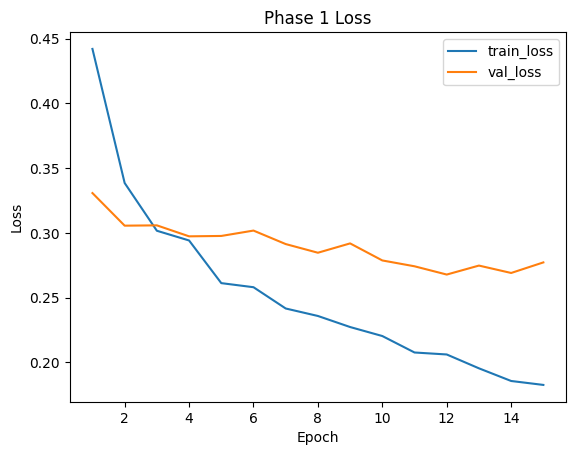

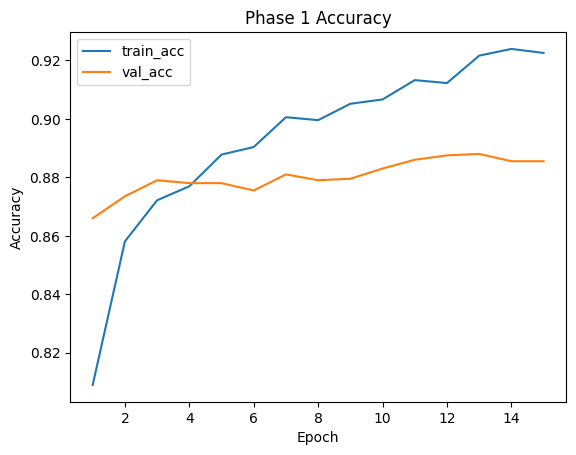

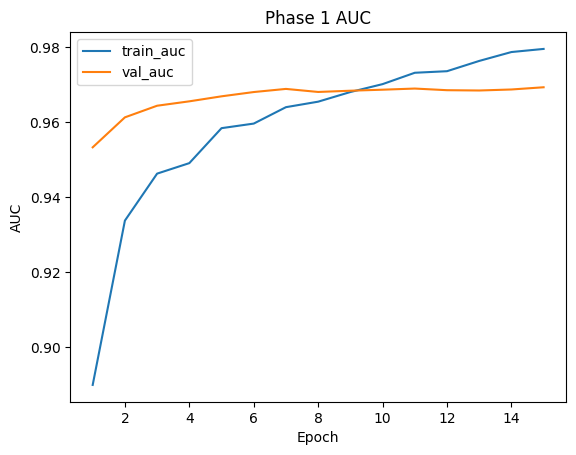

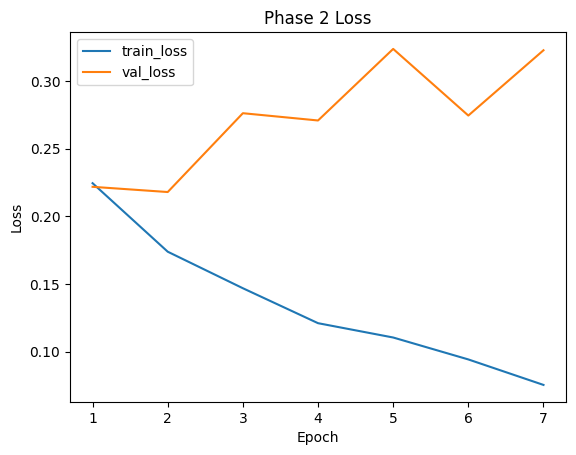

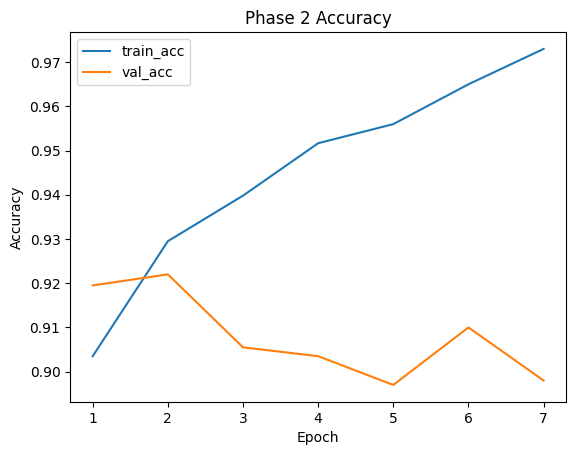

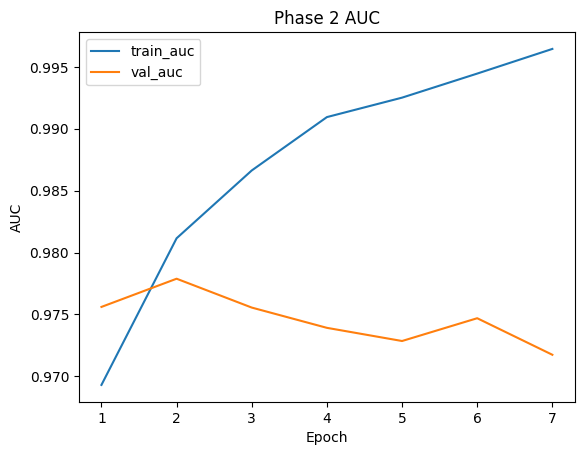

In [29]:
def plot_history(hist, title_prefix=""):
    h = hist.history
    epochs = range(1, len(next(iter(h.values()))) + 1)

    # LOSS
    plt.figure()
    plt.plot(epochs, h.get("loss", []), label="train_loss")
    plt.plot(epochs, h.get("val_loss", []), label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # ACCURACY (kalau ada)
    if "accuracy" in h:
        plt.figure()
        plt.plot(epochs, h.get("accuracy", []), label="train_acc")
        plt.plot(epochs, h.get("val_accuracy", []), label="val_acc")
        plt.title(f"{title_prefix} Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    # AUC (kalau ada)
    if "auc" in h:
        plt.figure()
        plt.plot(epochs, h.get("auc", []), label="train_auc")
        plt.plot(epochs, h.get("val_auc", []), label="val_auc")
        plt.title(f"{title_prefix} AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()

# Plot phase 1 & phase 2 kalau ada
try:
    plot_history(history_p1, "Phase 1")
except NameError:
    print("history_p1 tidak ditemukan, skip Phase 1 plot.")

try:
    plot_history(history_p2, "Phase 2")
except NameError:
    print("history_p2 tidak ditemukan, skip Phase 2 plot.")


### Phase 1

Dapat dilakukan evaluasi pada model menggunakan grafik Phase 1 Loss, Phase 1 Accuracy, serta grafik Phase 1 AUC:

**Phase 1 Loss Graph**
- Grafik ini menampilkan perbandingan training loss dan validation loss selama 15 epoch pada tahap pertama transfer learning
- Training loss (garis biru) menunjukkan penurunan yang sangat tajam dan konsisten dari kisaran 0.44 hingga berakhir di bawah 0.20 pada epoch ke-15. Hal ini menandakan bahwa lapisan custom head belajar dengan sangat cepat dalam mengenali pola fitur yang diekstraksi oleh MobileNetV2
- Validation loss (garis oranye) menurun secara stabil dari 0.33 dan mulai melandai di kisaran 0.27 pada akhir epoch. Berbeda dengan base model sebelumnya, grafik ini terlihat jauh lebih stabil dengan fluktuasi yang sangat minim
- Tren kedua garis yang terus menurun secara berdampingan mengindikasikan bahwa model berada pada jalur pelatihan yang benar tanpa adanya tanda-tanda overfitting yang signifikan

**Phase 1 Accuracy & AUC Graph**
- Training accuracy meningkat pesat dari 81% menjadi sekitar 92%, sementara Validation accuracy menunjukkan peningkatan yang stabil hingga mencapai angka konstan di kisaran 88%–89%
- Phase 1 AUC menunjukkan performa yang baik, di mana nilai validation AUC (garis oranye) tetap stabil tinggi di angka 0.97. Hal ini membuktikan bahwa model memiliki kemampuan yang sangat kuat dalam membedakan antara kelas AI_GENERATED dan NON_AI_GENERATED
- Stabilitas pada grafik AUC dan Akurasi menunjukkan bahwa penggunaan fitur pre-trained dari MobileNetV2 memberikan fondasi yang jauh lebih konsisten dibandingkan melatih model dari awal

Secara keseluruhan, kedua grafik memperlihatkan performa yang sangat impresif dan stabil dibandingkan base model. Penggunaan Transfer Learning terbukti berhasil menekan fluktuasi pada data validasi dan meningkatkan standar akurasi serta AUC secara signifikan. Gap yang kecil antara data training dan validation menunjukkan bahwa model memiliki kemampuan generalisasi yang sangat baik dalam mendeteksi gambar buatan AI

Dalam project ini, performa model akan dioptimalkan lebih lanjut melalui tahap Fine-Tuning (Phase 2) dengan membuka beberapa top layers pada MobileNetV2 untuk mendapatkan hasil recall yang lebih presisi



### Phase 2

Dapat dilakukan evaluasi pada model menggunakan grafik Phase 2 Loss, Phase 2 Accuracy, serta grafik Phase 2 AUC:

**Phase 2 Loss Graph**
- Grafik ini menampilkan perbandingan training loss dan validation loss selama 7 epoch pada tahap fine-tuning (setelah membuka 60 layer terakhir MobileNetV2)
- Training loss (garis biru) terus menunjukkan penurunan yang sangat konsisten, mencapai nilai di bawah 0.10 pada epoch ke-7. Hal ini menandakan bahwa model berhasil menyesuaikan bobot pada top layers untuk mengenali fitur spesifik dataset dengan sangat mendalam
- Validation loss (garis oranye) menunjukkan tren yang sangat fluktuatif dan cenderung meningkat secara bertahap setelah epoch ke-2, berakhir di kisaran 0.32. Kenaikan ini mengindikasikan bahwa model mulai mencapai batas generalisasinya pada tahap fine-tuning
- Adanya gap yang cukup lebar (0.12) antara garis biru dan oranye menunjukkan bahwa meskipun model semakin pintar pada data training, risiko overfitting menjadi lebih tinggi pada fase ini karena parameter yang dapat dilatih semakin banyak

**Phase 2 Accuracy & AUC Graph**
- Training Accuracy meningkat hingga menyentuh angka 97%, namun Validation Accuracy justru mengalami penurunan yang tidak stabil setelah mencapai puncak di epoch ke-2 (92%), berakhir di angka 90%
- Phase 2 AUC pada data training mencapai nilai hampir sempurna (0.996), tetapi pada data validation, nilai AUC cenderung menurun dari 0.978 ke arah 0.972. Hal ini mempertegas bahwa model sangat percaya diri dalam membedakan kelas pada data latihan, namun sedikit kehilangan kestabilan pada data baru

Secara keseluruhan, Phase 2 berhasil meningkatkan kemampuan model dalam mengenali detail fitur dataset secara ekstrem pada data training. Namun, fluktuasi pada akurasi dan loss validasi menunjukkan bahwa fine-tuning pada lapisan yang lebih dalam memerlukan pengawasan ketat terhadap overfitting. Meskipun demikian, nilai AUC validasi yang tetap bertahan di angka 0.97 menunjukkan model tetap memiliki performa dalam membedakan kelas yang sangat tinggi

Dalam project ini, hasil terbaik dari tahap fine-tuning (epoch ke-2 di mana validation loss terendah) akan digunakan sebagai model final untuk mendapatkan hasil recall yang paling optimal dalam mendeteksi gambar AI_GENERATED



# **G. Model Evaluation (Transfer Learning)**

#### Classification Report

In [30]:
best_tl_phase2 = load_model("best_tl_phase2.keras")
y_prob = best_tl_phase2.predict(test_set)

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step


In [ ]:
# Pakai model terbaik dari checkpoint fine-tuning
try:
    tl_best = load_model("best_tl_phase2.keras")
except Exception:
    # fallback kalau file phase2 belum ada
    tl_best = load_model("best_tl_phase1.keras")

from sklearn.metrics import classification_report

y_prob = tl_best.predict(test_set)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(
    test_set.classes,
    y_pred,
    target_names=list(test_set.class_indices.keys())
))

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step
                  precision    recall  f1-score   support

    AI_GENERATED       0.88      0.96      0.92      2000
NON_AI_GENERATED       0.96      0.86      0.91      2000

        accuracy                           0.91      4000
       macro avg       0.92      0.91      0.91      4000
    weighted avg       0.92      0.91      0.91      4000



Dari classification report setelah penerapan Transfer Learning dan Fine-Tuning, didapatkan hasil tiap kelas sebagai berikut:

**AI_GENERATED**
- Precision 88% artinya dari seluruh gambar yang diprediksi sebagai AI_GENERATED, sebanyak 88% benar-benar merupakan hasil buatan AI
- Recall 96% menunjukkan performa yang sangat baik dan mengalami peningkatan dalam mendeteksi gambar buatan AI, dari 2000 total data gambar AI yang ada, model berhasil menangkap 1920 gambar (True Positive). Nilai recall yang sangat tinggi ini merupakan pencapaian utama project, karena model memiliki performa yang baik dalam meminimalisir adanya gambar AI yang lolos sebagai gambar asli / False Negative
- F1-Score 92% menandakan performa yang sangat tinggi dan seimbang, membuktikan bahwa penggunaan MobileNetV2 sangat efektif dalam mengenali karakteristik unik gambar buatan AI secara akurat

**NON_AI_GENERATED**
- Precision 96% menunjukkan tingkat kepercayaan yang sangat tinggi mencapai 96% ketika model menyatakan sebuah gambar adalah asli (bukan AI)
- Recall 86% berarti model berhasil mengidentifikasi 1720 dari 2000 total gambar asli yang ada. Meskipun meningkat dari model sebelumnya, terdapat sekitar 14% gambar asli yang masih salah diklasifikasikan sebagai buatan AI (False Positive). Dalam konteks confusion matrix, ini menunjukkan model masih terlalu sensitif dalam mencurigai gambar asli sebagai hasil AI
- F1-Score 91% mengindikasikan kemampuan model dalam mengklasifikasikan gambar asli sudah sangat stabil dan mendekati performa kelas AI

Secara keseluruhan, model mencapai akurasi 91% pada 4000 data uji. Fokus utama project ini pada metrik Recall memperlihatkan hasil yang sangat positif:

- Sangat tingginya recall pada kelas AI (96%) berbanding lurus dengan drastisnya penurunan jumlah False Negatives pada confusion matrix. Ini berarti model hampir tidak pernah gagal dalam mengidentifikasi gambar yang dibuat oleh AI
- Terdapat trade-off yang lebih baik, di mana model tetap mengutamakan keamanan deteksi AI. Meskipun recall NON_AI (86%) lebih rendah, angka ini sudah jauh lebih baik dibandingkan base model, yang berarti lebih sedikit gambar asli yang harus ditinjau lebih lanjut karena salah deteksi
- Nilai macro average dan weighted average yang konsisten di angka 91%-92% membuktikan bahwa strategi Transfer Learning dengan MobileNetV2 memberikan fondasi yang sangat kokoh dan cerdas. Model kini jauh lebih handal dan siap digunakan untuk membedakan antara konten asli dan buatan AI secara profesional

#### Confusion Matrix

125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step
Class indices: {'AI_GENERATED': 0, 'NON_AI_GENERATED': 1}

Confusion Matrix:
[[1921   79]
 [ 274 1726]]


<Figure size 500x500 with 0 Axes>

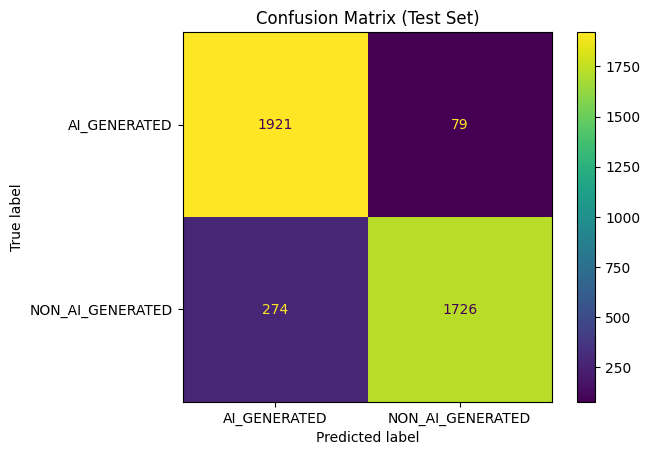

Kelas-1 salah diprediksi sebagai kelas-0: 274/2000 (0.137)


In [ ]:
# Pakai model terbaik dari checkpoint fine-tuning
try:
    tl_best = load_model("best_tl_phase2.keras")
except Exception:
    # fallback kalau file phase2 belum ada
    tl_best = load_model("best_tl_phase1.keras")

# Predict
y_prob = tl_best.predict(test_set, verbose=1).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_set.classes

# Confusion Matrix (angka)
cm = confusion_matrix(y_true, y_pred)

print("Class indices:", test_set.class_indices)
print("\nConfusion Matrix:")
print(cm)

# Confusion Matrix (plot)
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_set.class_indices.keys())
)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Analisis error per kelas (lihat class_indices di atas)
non_ai_wrong_as_ai = cm[1, 0]
non_ai_total = cm[1].sum()

print(
    f"Kelas-1 salah diprediksi sebagai kelas-0: "
    f"{non_ai_wrong_as_ai}/{non_ai_total} "
    f"({non_ai_wrong_as_ai / non_ai_total:.3f})"
)

Matrix terdiri dari:
- Baris yang merupakan actual image
- Kolom yang merupakan hasil prediksi model

**Pembahasan Tiap Cell**

True Positive (TP) = 1921
- Gambar AI-generated yang diprediksi dengan benar sebagai gambar AI-generated
- Menunjukkan performa yang baik untuk mendeteksi gambar AI-generated

False Negative (FN) = 79
- Gambar AI-generated yang diprediksi dengan salah sebagai gambar Non-AI
- Akan berbahaya untuk project ini jika nilainya besar
- Model ini gagal mendeteksi 79 dari 2000 gambar atau 3.95%, sehingga dapat diinterpretasikan sebagai dari 100 AI-generated image, model gagal mendeteksi 4 gambar, di mana ini cukup baik

False Positive (FP) = 274
- Gambar Non-AI yang diprediksi dengan salah sebagai gambar AI
- Akan berbahaya untuk project ini karena salah melabel gambar non-AI sebagai AI, sehingga akan dilakukan peninjauan lebih lanjut oleh reviewer
- Model ini gagal mendeteksi 274 dari 2000 gambar atau 13,7%, sehingga dapat diinterpretasikan sebagai dari 100 gambar non-AI, model gagal mendeteksi 14 gambar, di mana ini cukup besar, maka dibutuhkan peninjauan lebih lanjut

True Negative (TN) = 1726
- Gambar Non-AI yang diprediksi dengan benar sebagai gambar Non-AI
- Menunjukkan performa yang masih belum terlalu baik untuk mendetaksi gambar Non-AI

Sehingga bisa disimpulkan bahwa model ini dapat digunakan untuk mendeteksi gambar buatan AI karena recall yang tinggi dan hanya sedikit gambar buatan AI yang tidak terdeteksi. Namun ada beberapa gambar non-AI yang akan terdeteksi sebagai AI karena model sangat cenderung untuk melabeli gambar sebagai AI untuk memaksimalkan performa filtrasi

**Improvement Recommendation**

Untuk mengurangi gambar non-AI yang diprediksi sebagai gambar AI (False Positive) dapat dilakukan:
- Meningkatkan threshold prediction(dari 0.5 menjadi 0.6)
- Tambahkan gambar non-AI yang lebih beragam lagi pada dataset train

### Improvement Overview

Dua metric yang penting dalam menunjukkan keberhasilan model dalam menekan kesalahan klasifikasi adalah: Recall AI menunjukkan kemampuan menangkap gambar AI (meminimalkan False Negative), dan Precision Non-AI yang menunjukkan tingkat kepercayaan bahwa gambar yang dinyatakan asli memang benar-benar asli

Berikut adalah tabel perbandingan performa yang lengkap mencakup seluruh metrik:

### Tabel Perbandingan Performa

| Kelas | Metrik | Base Model CNN | Final Model (MobileNetV2) | Peningkatan |
| --- | --- | --- | --- | --- |
| **AI_GENERATED** | **Recall** | 88% | **96%** | +8% |
|  | **Precision** | 83% | **88%** | +5% |
| **NON_AI_GENERATED** | **Recall** | 82% | **86%** | +4% |
|  | **Precision** | 88% | **96%** | +8% |
| **KESELURUHAN** | **Accuracy** | 85% | **91%** | +6% |

### Penjelasan Mengapa Seluruh Metrik Ini Penting:

* Recall AI (96%) & Precision Non-AI (96%): Kedua angka yang identik ini menunjukkan kekuatan model dalam aspek mencapai tujuan project. Model akan jarang meloloskan gambar AI sebagai gambar asli (Recall AI tinggi), dan ketika model mengatakan sebuah gambar itu asli, tingkat kebenarannya sangat tinggi (Precision Non-AI tinggi). Hal ini sangat krusial karena model kini akan memiliki performa baik dalam menangkap gambar buatan AI dan meminimalisir risiko gambar AI dianggap sebagai gambar asli (False Negative)
* Precision AI (88%): Peningkatan dari 83% ke 88% menunjukkan bahwa model kini lebih akurat dalam melabeli AI. Artinya, jumlah gambar asli yang dianggap sebagai AI / False Positive berkurang.
* Recall Non-AI (86%): Ini adalah metrik yang menunjukkan kemampuan model dalam mengkategorikan gambar asli agar tidak terbuang. Peningkatan dari 82% ke 86% membuktikan bahwa improvement pada MobileNetV2 berhasil memperbaiki sensitivitas model terhadap gambar asli dibandingkan Base Model

**Key Takeaway**

Project ini berhasil membuktikan bahwa strategi Transfer Learning dengan MobileNetV2 adalah solusi yang jauh lebih efektif untuk klasifikasi gambar biner (AI vs Non-AI). Model final tidak hanya lebih akurat secara keseluruhan (91%), tetapi juga sangat unggul dalam metrik target utama yaitu Recall (96%), menjadikannya alat deteksi yang sangat handal dalam mengenali konten buatan AI

# **H. Kesimpulan**

**Data dan Model**
- Project ini bertujuan untuk membangun model klasifikasi gambar AI-Generated dan Non-AI Generated. Tujuan utama model adalah untuk membantu mendeteksi keaslian gambar di tengah meningkatnya penggunaan AI-generated content yang berpotensi menimbulkan penyalahgunaan

- Dilakukan augmentasi data hanya pada data train dan normalisasi pada seluruh data. Semua gambar diseragamkan ukurannya menjadi (224, 224) untuk menyesuaikan dengan arsitektur model yang digunakan

- Model Baseline yang digunakan pada tahap awal menunjukkan keterbatasan dalam menangkap fitur kompleks yang membedakan gambar AI dengan gambar asli, sehingga performa awal belum optimal

- Model kemudian dikembangkan dengan pendekatan Transfer Learning menggunakan MobileNetV2 dengan bobot pre-trained ImageNet dipilih untuk meningkatkan performa model. Model diimplementasikan dengan strategi fine-tuning layer tertentu agar model dapat menyesuaikan dengan karakteristik dataset

- Penerapan Transfer Learning terbukti signifikan meningkatkan performa model

- Berdasarkan Classification Report, model memiliki performa yang sangat baik dalam mendeteksi gambar AI-Generated, ditunjukkan oleh nilai precision dan recall yang tinggi, serta didukung oleh Confusion Matrix

- Meskipun performa model sudah baik, masih terdapat potensi overfitting ringan, di mana performa pada data training sedikit lebih tinggi dibandingkan data validasi. Hal ini menunjukkan perlunya improvement lanjutan untuk menghasilkan model dengan kondisi good fit

**Use Case Recommendation**
- Model klasifikasi AI Generated Image ini dapat diintegrasikan ke dalam sistem verifikasi konten digital sebagai tool untuk filtrasi awal, sebelum dilakukan peninjauan manual lebih lanjut
- Bisa digunakan untuk art competition untuk meminimalisir submission artwork AI-generated yang akan menimbulkan perselisihan

**Kelebihan dan Kekurangan**

Kelebihan:
- Mampu mebedakan gambar AI-generated dan Non-AI dengan performa tinggi
- Transfer Learning terbukti meningkatkan akurasi dan stabilitas model
- Confusion Matrix menunjukkan tingkat kesalahan klasifikasi yang relatif rendah

Kekurangan:
- Model masih sensitif terhadap pola visual tertentu yang mirip antara gambar AI dan Non-AI
- Model akan cukup sering mendeteksi gambar Non-AI sebagai AI untuk gambar yang ambigu karena mengutamakan filtrasi gambar AI agar tidak lolos
- Model memiliki performa yang buruk jika ada noise dan juga elemen tambahan seperti background atau objek lain 
- Masih terdapat overfitting ringan

**Improvement Plan**
- Menambah dan memperkaya dataset dengan melakukan update train set periodik bulanan
- Mencoba arsitektu model lain seperti EfficientNet, ConvNeXt, atau Vision Transformer
- Menambah regularisasi tambahan (Dropout, weight decay) untuk mengurangi overfitting
- Mengembangkan approach lanjutan seperti penggunaan ensemble model dan pendeteksian diffusion model atau teknik generative-aware features
- Mengkombinasikan klasifikasi dengan explainability (XAI) agar keputusan model lebih mudah diinterpretasikan



# **I. Saran Penggunaan**

- Untuk submit gambar, pastikan gambar tersebut tergolong artwork dan bukan gambar general, karena model ini ditrain dengan dataset spesifik artwork

- Harus dipastikan submission gambar dalam bentuk jpg, jpeg, dan png serta tidak memilki background transparan agar model dapat mendeteksi gambar dengan baik